In [1]:
import pandas as pd

import pandas as pd

import numpy as np
import seaborn as sns
import sys
import json
import ast

import matplotlib.image as mpimg
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

%load_ext autoreload

%autoreload 2

sys.path.append("../")
from protocols import utils

import warnings

In [2]:

mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()

#read in the mutations tables, subsetted down to BDQ WHO-defined candidate genes
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()
#GARC mutation naming
mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
#flag sysnonymous mutations
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
#flag null calls
mutations["IS_NULL"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1]  == 'Z'
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)
#fill in nucleotide indexes for mmpL5 
gene_positions = {'Rv0678':778990, 'mmpL5':775586, 'pepQ':2859300, 'atpE':1461045, 'mmpS5':778477 }
mutations['NUCLEOTIDE_INDEX'] = mutations.apply(
    lambda row: gene_positions[row['GENE']] + 
                (row['NUCLEOTIDE_NUMBER'] if pd.notna(row['NUCLEOTIDE_NUMBER']) else row['GENE_POSITION']),
    axis=1
)

#read in table of genomes
genomes = pd.read_csv("./data/GENOMES.csv.gz").reset_index()

mutations = mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])]

#read in cyrptic samples
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz").reset_index()
phenotypes_cryptic_samples = set(phenotypes_cryptic.UNIQUEID)
#filter for high quality phenotypes from UKMYC5 and UKMYC6 plates
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.UNIQUEID.isin(genomes.UNIQUEID)]

assert phenotypes_cryptic.UNIQUEID.nunique() == len(phenotypes_cryptic.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in new nicd samples
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz").reset_index()
phenotypes_nicd_samples = set(phenotypes_nicd.UNIQUEID)
#filter for mgit samples
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].UNIQUEID
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(has_mgit)]
#filter for samples with genomes
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(genomes.UNIQUEID)]
# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)

#combine cryptic and nicd phenotype tables
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"
phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
assert phenotypes.UNIQUEID.nunique() == len(phenotypes.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in growth data of the cryptic plates
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])

all = pd.merge(mutations, samples, how='right', on=['UNIQUEID'])
all.dropna(subset=['METHOD_MIC'], inplace=True)
all['GENE'].fillna('None', inplace=True)

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

In [3]:
all['MUTATION'] = all.apply(
    lambda row: f"{row['GENE']}@{int(row['GENE_POSITION'])}_indel" 
    if (pd.notna(row['GENE_POSITION']) and ('ins' in row['MUTATION'] or 'del' in row['MUTATION']))
    else row['MUTATION'], 
    axis=1
)

In [63]:
synonymous_mgit = []
synonymous_plate = []
wt_mgit = []
wt_plate = []

for i in all.UNIQUEID.unique():
    df = all[all.UNIQUEID == i]
    if df.METHOD_2.iloc[0] == 'MGIT':
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_mgit.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):  
            wt_mgit.append(df.UNIQUEID.iloc[0])
    else:
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_plate.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):
            wt_plate.append(df.UNIQUEID.iloc[0])

mgit_wts = all[all.UNIQUEID.isin(synonymous_mgit+wt_mgit)]
plate_wts = all[all.UNIQUEID.isin(synonymous_plate+wt_plate)]

mgit_mutants = all[(all.METHOD_2=='MGIT')&(~all.UNIQUEID.isin(synonymous_mgit+wt_mgit))]
plate_mutants = all[(all.METHOD_2=='microdilution plate')&(~all.UNIQUEID.isin(synonymous_plate+wt_plate))]
mgit = pd.concat([mgit_mutants, mgit_wts])

In [80]:
mgit_wts.METHOD_MIC.value_counts()

0.5        50
0.25       32
1          26
2          13
<=0.125    12
4          10
8           5
Name: METHOD_MIC, dtype: int64

In [6]:
def process_mic_data(df):
    y_low = []
    y_high = []

    dilution_factor = 2
    tail_dilution_factor = dilution_factor ** 3 #3 doubling dilutions (or 3 log2MICs) censored extension on either side

    for mic in df['METHOD_MIC']:
        if mic.startswith('<='):
            lower_bound = float(mic[2:])
            y_low.append(lower_bound / tail_dilution_factor)  # Adjust for left-censoring
            y_high.append(lower_bound)
        elif mic.startswith('>'):
            upper_bound = float(mic[1:])
            y_low.append(upper_bound)
            y_high.append(upper_bound * tail_dilution_factor)  # Adjust for right-censoring
        else:
            # For exact MIC values, the interval is MIC - 1 doubling dilution
            mic_value = float(mic)
            y_low.append(mic_value / dilution_factor)
            y_high.append(mic_value)
            
    #return lower and upper bound arrays rounded to 3 decimal places
    return np.round(np.array(y_low), 3), np.round(np.array(y_high), 3)

In [201]:
def log_likelihood_mixed_effects(params, y_low, y_high, X, clusters):
    beta = params[:X.shape[1]]  # Fixed effects
    u = params[X.shape[1]:-1]  # Random effects for clusters
    sigma = params[-1]  # Standard deviation

    # Predicted mean for each sample
    mu = np.dot(X, beta) + u[clusters]  # Use cluster numeric IDs for random effects

    log_L = 0

    # Likelihood for left-censored values
    left_censored = y_low == -5.96578428
    if np.any(left_censored):
        log_L += np.sum(norm.logcdf((y_high[left_censored] - mu[left_censored]) / sigma))

    # Likelihood for right-censored values
    right_censored = (y_high == 4) | (y_high == 6)
    if np.any(right_censored):
        log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu[right_censored]) / sigma)))

    # Likelihood for interval-censored values
    interval_censored = ~left_censored & ~right_censored & (y_low != y_high)
    if np.any(interval_censored):
        log_L += np.sum(
            np.log(
                norm.cdf((y_high[interval_censored] - mu[interval_censored]) / sigma)
                - norm.cdf((y_low[interval_censored] - mu[interval_censored]) / sigma)
            )
        )

    return -log_L  # Minimize the negative log-likelihood

In [215]:
all_mutations = pd.read_pickle('/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/cryptic-tables-v2.1.1/MUTATIONS.pkl.gz').reset_index()
all_mutations = all_mutations[all_mutations.UNIQUEID.isin(mgit.UNIQUEID)]
all_mutations.to_csv('./data/ignore/bdq_all_samples.csv')

In [218]:
# Random effects - need to generate Z matrix, which represents the genomic cluster id random effect variable
# shape = (samples, n_clusters), with OHE membership to columns (cluster id flags, basically)
# need to caslculate whole-genome snp distances - therefore need wider MUTATIONS table, but will filter down to relevant isolates


# filter for snps

def cluster_coordinates(mutations_df, samples_df, distance):

    all_mutations = mutations_df
    
    all_mutations.dropna(subset="ALT", inplace=True)
    all_mutations["SNP_ID"] = (
        all_mutations["GENE"]
        + "_"
        + all_mutations["GENE_POSITION"].astype(str)
        + "_"
        + all_mutations["REF"]
        + "_"
        + all_mutations["ALT"]
    )

    # Build the SNP matrix (binary matrix where 1 = mutation, 0 = no mutation)
    snp_matrix = pd.pivot_table(
        all_mutations,
        index="UNIQUEID",
        columns="SNP_ID",
        aggfunc="size",
        fill_value=0
    )

    snp_matrix = snp_matrix.applymap(lambda x: 1 if x > 0 else 0)

    # Include all UNIQUEIDs from the original dataset (to ensure WT samples are included)
    unique_ids = samples_df["UNIQUEID"].unique()
    snp_matrix = snp_matrix.reindex(unique_ids, fill_value=0)

    # Calculate pairwise distances (Hamming distance)
    dist_matrix = pairwise_distances(snp_matrix, metric='hamming')

    # Perform Agglomerative Clustering on the distance matrix
    agg_cluster = AgglomerativeClustering(
        metric='precomputed',
        linkage='complete',
        distance_threshold=distance/len(snp_matrix.columns),  # Hamming threshold conversion
        n_clusters=None
    )

    # Cluster IDs for samples with mutations
    cluster_ids = agg_cluster.fit_predict(dist_matrix)

    return cluster_ids



In [203]:


#create Z matrix (n_samples, n_clusters (ohe))
#n_samples = len(cluster_ids)
#n_clusters = np.unique(cluster_ids).size

# Initialize the Z matrix with zeros
#Z = np.zeros((n_samples, n_clusters))

# Populate the Z matrix
#for i in range(n_samples):
    #Z[i, cluster_ids[i]] = 1

#print ('Random effects matrix:', Z.shape)

In [204]:
#Fixed effects:

#siteid and lineage:

#siteids = pd.get_dummies(mgit_mutants['SITEID'], drop_first=True)
#X = siteids.values

#mutation matrix and interaction terms:

# pivot the DataFrame to create a binary matrix where rows = samples and columns = unique non-synonymous  mutations
def build_X(df):
    
    # Get all unique IDs from the input DataFrame
    unique_ids = df['UNIQUEID'].unique()

    mut_matrix = pd.pivot_table(
        df,
        index="UNIQUEID",
        columns="MUTATION",
        aggfunc="size",  # counts occurrences
        fill_value=0,    # absence of the mutation
    )

    mut_matrix = mut_matrix.applymap(lambda x: 1 if x > 0 else 0)
    #reindex the matrix to ensure all unique IDs are present, even if they have no mutations
    mut_matrix = mut_matrix.reindex(unique_ids, fill_value=0)

    return mut_matrix



#include interation terms for pairs of mutations that co occur 5 or more times

'''mutation_counts = (mut_matrix.sum(axis=0) >= 2)
valid_mutations = mutation_counts[mutation_counts].index

pair_counts = (mut_matrix[valid_mutations].T @ mut_matrix[valid_mutations])
pair_counts = np.tril(pair_counts, -1)  # Use lower triangle to avoid duplicates

valid_pairs = np.argwhere(pair_counts >= 2)
mutation_pairs = [(valid_mutations[i], valid_mutations[j]) for i, j in valid_pairs]

for mut1, mut2 in mutation_pairs:
    interaction_col = mut_matrix[mut1] * mut_matrix[mut2]
    X[f'{mut1}_x_{mut2}'] = interaction_col'''


"mutation_counts = (mut_matrix.sum(axis=0) >= 2)\nvalid_mutations = mutation_counts[mutation_counts].index\n\npair_counts = (mut_matrix[valid_mutations].T @ mut_matrix[valid_mutations])\npair_counts = np.tril(pair_counts, -1)  # Use lower triangle to avoid duplicates\n\nvalid_pairs = np.argwhere(pair_counts >= 2)\nmutation_pairs = [(valid_mutations[i], valid_mutations[j]) for i, j in valid_pairs]\n\nfor mut1, mut2 in mutation_pairs:\n    interaction_col = mut_matrix[mut1] * mut_matrix[mut2]\n    X[f'{mut1}_x_{mut2}'] = interaction_col"

Issue is - the NICD WT samples all have the same SITEID (and we dont have lineage data) - therefore, cant really had the fixed effects for this. But in essence, do the above and concat the various fixed effect matrixes together.

In [205]:

# Initialize the scaler
#scaler = StandardScaler()
# Fit the scaler to y_low_log and y_high_log
#y_low_log = scaler.fit_transform(y_low_log.reshape(-1, 1)).flatten()
#y_high_log = scaler.transform(y_high_log.reshape(-1, 1)).flatten()


In [257]:
def predicted_effects(result, X, p):
    # Extract only the first p elements of the result, which correspond to the mutation effects
    fixed_effects_coefficients = result.x[:p]

    # Sigma (standard deviation)
    sigma = result.x[-1]

    # Create DataFrame for mutation effects
    mutation_effects = pd.DataFrame({
        'Mutation': X.columns,  # The names of the mutations from X
        'Effect_Size': fixed_effects_coefficients
    })

    # Convert effect sizes to MIC values (by reversing the log transformation)
    mutation_effects['MIC'] = 2**mutation_effects['Effect_Size']

    if hasattr(result, 'hess_inv'):
        hess_inv_dense = result.hess_inv.todense()  # Convert to a dense matrix
        # Extract the diagonal elements corresponding to the fixed effects (log2(MIC) scale)
        effect_std_log2 = np.sqrt(np.diag(hess_inv_dense)[:p])  # Standard deviation of log2(MIC)
        mutation_effects['Effect_Std'] = effect_std_log2
        # Convert standard deviation to MIC scale
        mutation_effects['MIC_Std'] = mutation_effects['MIC'] * np.log(2) * mutation_effects['Effect_Std']
        mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'Effect_Std', 'MIC', 'MIC_Std']]
    else:
        mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'MIC']]

    return mutation_effects




## Fit model to mutants only

In [230]:
#random effects
#all_mutations = pd.read_pickle('/Users/dylanadlard/Documents/Oxford/PhD/Projects/BDQ_analysis/cryptic-tables-v2.1.1/MUTATIONS.pkl.gz').reset_index()
#all_mutations = all_mutations[all_mutations.UNIQUEID.isin(mgit_mutants.UNIQUEID)]
#all_mutations.to_csv('./data/ignore/bdq_all_mutations.csv')

all_mutations = pd.read_csv("./data/ignore/bdq_all_mutations.csv", index_col=0)
cluster_ids = cluster_coordinates(all_mutations, mgit_mutants, distance=25)

X = build_X(mgit_mutants)
#convert sample MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(mgit_mutants.drop_duplicates(subset='UNIQUEID', keep='first'))
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))

#initialise coefficients and standard deviation
# Number of fixed effects
p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

fixed_effect_bounds = [(-6, 6)] * X.shape[1]
random_effect_bounds = [(None, None)] * n_clusters
sigma_bound = [(1e-5, None)]
bounds = fixed_effect_bounds + random_effect_bounds + sigma_bound


In [91]:

result_tc = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='trust-constr',
    bounds=bounds,  # Sigma must be positive
    options={        'maxiter': 1000,          # Maximum iterations
        'gtol': 1e-3,             # Tolerance for gradient norm (similar to tol)
        'xtol': 1e-8,             # Tolerance for step size changes
        'barrier_tol': 1e-8,      # Barrier method tolerance
        'verbose': 3   }  # Increase the max iterations and function evaluations
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  657  |   0   | +1.1862e+03 | 1.00e+00 | 7.07e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   | 1314  |   1   | +9.3837e+02 | 2.00e+00 | 1.29e+02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   | 1971  |   3   | +9.2325e+02 | 1.12e+01 | 8.18e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   4   | 2628  |   6   | +9.0671e+02 | 3.67e+01 | 2.63e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   | 3285  |   9   | +9.0273e+02 | 3.67e+01 | 2.17e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   6   | 3942  |  12   | +9.0058e+02 | 3.67e+01 | 2.17e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   | 4599  |  15   | +8.9819e+02 | 3.67e+01 | 3.25e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   | 5256  |  19   | +8.9329e+02 | 3.67e+

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_13401/1822938747.py:25: RuntimeWarning: divide by zero encountered in log
  np.log(
/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


|  64   | 47304 |  555  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|  65   | 47961 | 1211  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  66   | 47961 | 1867  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  67   | 47961 | 2523  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  68   | 47961 | 3179  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  69   | 47961 | 3835  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  70   | 47961 | 4491  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  71   | 47961 | 5147  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  72   | 47961 | 5803  | +5.1403e+01 | 1.70e-01 | 3.70e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|  73   | 47961 | 6459  | +5.1403e+01 | 1.70e-

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_13401/1822938747.py:19: RuntimeWarning: divide by zero encountered in log
  log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu[right_censored]) / sigma)))


In [231]:
result_bfgs = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='L-BFGS-B',
    bounds = [(None, None)] * (X.shape[1] + n_clusters) + [(1e-7, None)],  # Adjust bounds for the random effects and sigma
    options={'maxiter': 100000, 'maxfun': 500000}  # Increase the max iterations and function evaluations
)


In [258]:
mut_bfgs = predicted_effects(result_bfgs, X, p)
mut_bfgs

,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
0,Rv0678@-7_indel,0.030785,1.459037,1.021568,1.033139
1,Rv0678@128_indel,0.446010,1.054711,1.362267,0.995913
2,Rv0678@130_indel,0.603296,1.016627,1.519183,1.070526
3,Rv0678@132_indel,1.372331,12.060420,2.588885,21.642161
4,Rv0678@133_indel,0.850786,1.076965,1.803484,1.346292
...,...,...,...,...,...
213,pepQ@Q5!,0.356783,4.283467,1.280567,3.802097
214,pepQ@S200L,0.758998,1.008415,1.692315,1.182894
215,pepQ@S66P,-2.258741,2.410521,0.208954,0.349130
216,pepQ@V102I,-1.259330,1.138356,0.417738,0.329615


In [233]:
mut_bfgs[mut_bfgs.Mutation=='Rv0678@192_indel']b


,Mutation,Effect_Size,MIC,MIC_Std
18,Rv0678@192_indel,1.096453,2.138283,1.658494


## Fit model to all samples

In [259]:

all_mutations = pd.read_csv("./data/ignore/bdq_all_samples.csv", index_col=0)
cluster_ids = cluster_coordinates(all_mutations, mgit, distance=25)


X = build_X(mgit)
#convert sample MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(mgit.drop_duplicates(subset='UNIQUEID', keep='first'))
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))

#initialise coefficients and standard deviation
# Number of fixed effects
p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

fixed_effect_bounds = [(-6, 6)] * X.shape[1]
random_effect_bounds = [(None, None)] * n_clusters
sigma_bound = [(1e-5, None)]
bounds = fixed_effect_bounds + random_effect_bounds + sigma_bound

In [260]:
w_wt_result_bfgs = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='L-BFGS-B',
    bounds = [(None, None)] * (X.shape[1] + n_clusters) + [(1e-7, None)],  # Adjust bounds for the random effects and sigma
    options={'maxiter': 100000, 'maxfun': 500000}  # Increase the max iterations and function evaluations
)

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_13401/1822938747.py:25: RuntimeWarning: divide by zero encountered in log
  np.log(
/Users/dylanadlard/miniforge3/envs/BDQ_catalogue_builder/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [261]:
effects = predicted_effects(w_wt_result_bfgs, X, p)
effects

,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
0,Rv0678@-7_indel,0.557032,1.008196,1.471239,1.028143
1,Rv0678@128_indel,0.482856,1.019573,1.397507,0.987639
2,Rv0678@130_indel,0.530560,1.000935,1.444490,1.002180
3,Rv0678@132_indel,0.909151,0.993078,1.877940,1.292678
4,Rv0678@133_indel,0.944050,1.225670,1.923921,1.634505
...,...,...,...,...,...
213,pepQ@Q5!,0.789583,1.024026,1.728575,1.226944
214,pepQ@S200L,0.421321,1.005678,1.339153,0.933500
215,pepQ@S66P,-1.577659,1.047743,0.335025,0.243309
216,pepQ@V102I,-0.652336,1.036447,0.636249,0.457088


In [267]:
np.max(effects.Effect_Std)

1.5785313578976938

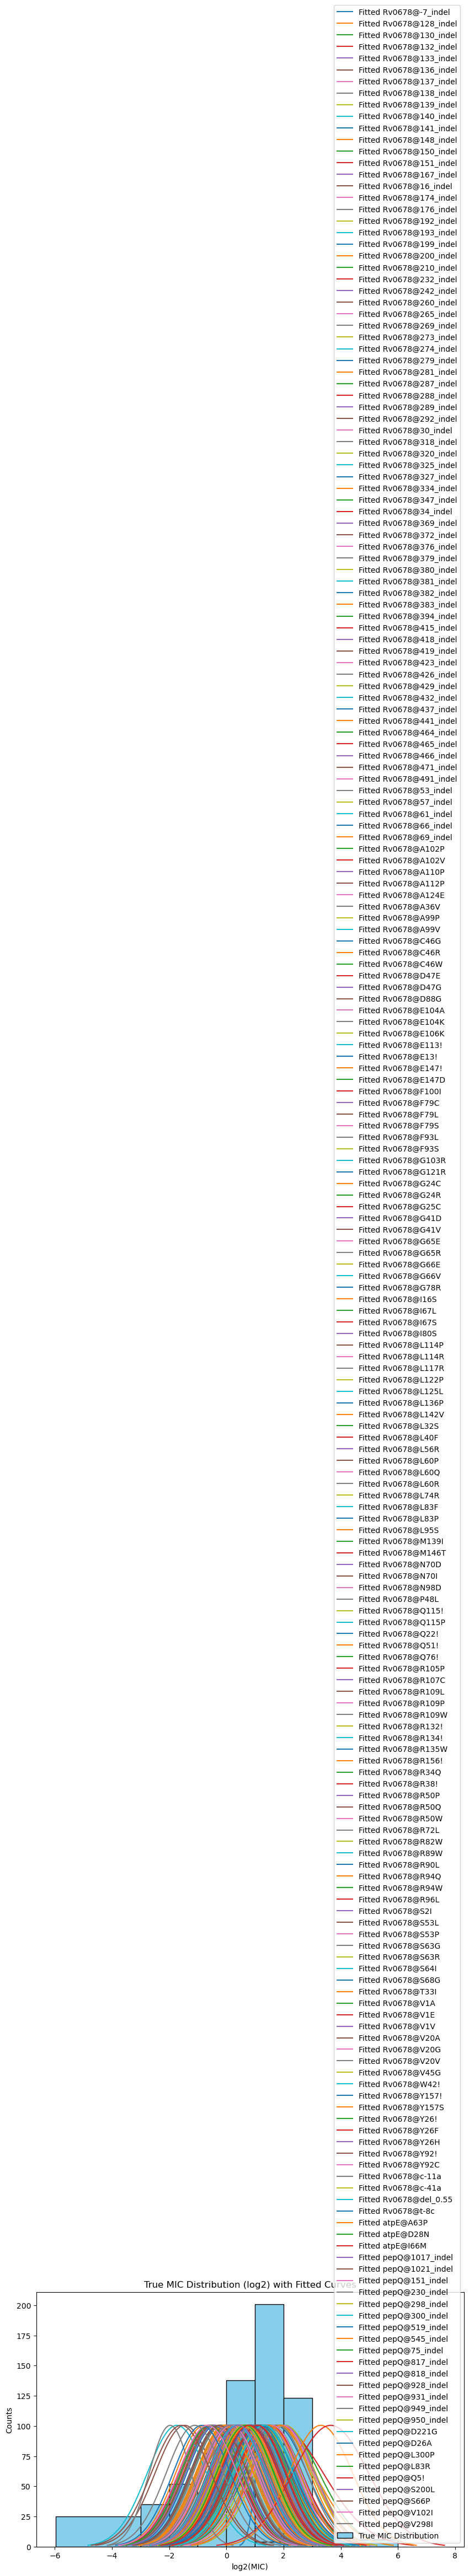

In [271]:
intervals = [(low, high) for low, high in zip(y_low_log, y_high_log)]

# Get unique intervals
unique_intervals = sorted(set(intervals))
# Calculate counts for each unique interval
mic_counts = [intervals.count(interval) for interval in unique_intervals]
# Extract the midpoints of the unique intervals for plotting
interval_midpoints = [(low + high) / 2 for low, high in unique_intervals]
# Extract widths for the bars (log2MIC range of each interval)
interval_widths = [high - low for low, high in unique_intervals]

plt.figure(figsize=(10, 6))
plt.bar(interval_midpoints, height=mic_counts, width=interval_widths,
        align='center', edgecolor='black', color='skyblue', label='True MIC Distribution')

for _, row in effects.iterrows():
    effect_size = row['Effect_Size']  # This is the log2(MIC) mean from the model
    effect_std = row['Effect_Std']    # This is the log2(MIC) std from the model
    
    # Generate the x-values for the fitted curve (log2 scale)
    x_values = np.linspace(effect_size - 3*effect_std, effect_size + 3*effect_std, 100)
    
    # Generate the normal distribution using effect size and std (fitted mean and std)
    y_values = norm.pdf(x_values, loc=effect_size, scale=effect_std)
    
    # Scale the normal distribution to match the height of the histogram
    y_values *= (max(mic_counts) / max(y_values))/2
    
    plt.plot(x_values, y_values, label=f'Fitted {row["Mutation"]}', linestyle='-')

plt.xlabel('log2(MIC)')
plt.ylabel('Counts')
plt.title('True MIC Distribution (log2) with Fitted Curves')
plt.legend()

In [282]:
unique_ids = mgit.UNIQUEID.unique().tolist()

# Assuming y_low is an array that has the same length as the unique UNIQUEIDs
# Create the mapping
id_to_y_low = {unique_ids[id]: y_low_log[id] for id in range(len(unique_ids))}
id_to_y_high = {unique_ids[id]: y_high_log[id] for id in range(len(unique_ids))}
mgit['y_low_log'] = mgit['UNIQUEID'].map(id_to_y_low)
mgit['y_high_log'] = mgit['UNIQUEID'].map(id_to_y_high)

mut_y_low_log = {mut: mgit.loc[mgit['MUTATION'] == mut, 'y_low_log'].to_numpy() 
                 for mut in mgit['MUTATION'].unique()}
mut_y_high_log = {mut: mgit.loc[mgit['MUTATION'] == mut, 'y_high_log'].to_numpy() 
                 for mut in mgit['MUTATION'].unique()}

In [255]:
for _, row in effect.iterrows():
    mutation_name = row['Mutation']
    effect_size = row['Effect_Size']  # log2MIC mean for the mutation
    effect_std = row['Effect_Std']    # log2MIC standard deviation for the mutation

    # Get the mutation-specific MIC intervals
    mutation_y_low_log = y_low_log[mutation_name]
    mutation_y_high_log = y_high_log[mutation_name]

    # Combine the low and high log2 MIC values into interval tuples for the current mutation
    mutation_intervals = [(low, high) for low, high in zip(mutation_y_low_log, mutation_y_high_log)]

    # Get unique intervals for the current mutation
    unique_intervals = sorted(set(mutation_intervals))

    # Calculate counts for each unique interval
    mutation_mic_counts = [mutation_intervals.count(interval) for interval in unique_intervals]

    # Extract the midpoints and widths for plotting the bars
    interval_midpoints = [(low + high) / 2 for low, high in unique_intervals]
    interval_widths = [high - low for low, high in unique_intervals]

    plt.figure(figsize=(10, 6))  # Create a new figure for each mutation
    
    # Step 1: Plot the histogram of calculated MIC intervals for this mutation
    plt.bar(interval_midpoints, height=mutation_mic_counts, width=interval_widths,
            align='center', edgecolor='black', color='skyblue', label='True MIC Distribution')

    # Step 2: Overlay the fitted normal distribution for the current mutation
    x_values = np.linspace(effect_size - 3*effect_std, effect_size + 3*effect_std, 100)
    
    # Generate the normal distribution using effect size and std (fitted mean and std)
    y_values = norm.pdf(x_values, loc=effect_size, scale=effect_std)
    
    # Scale the normal distribution to match the height of the histogram
    y_values *= max(mutation_mic_counts) / max(y_values)
    
    # Plot the fitted curve
    plt.plot(x_values, y_values, label=f'Fitted Curve for {mutation_name}', linestyle='-', color='red')
    
    # Customize the plot
    plt.xlabel('log2(MIC)')
    plt.ylabel('Counts')
    plt.title(f'MIC Distribution and Fitted Curve for {mutation_name}')
    plt.legend()

    # Show the plot for this mutation
    plt.show()

,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
18,Rv0678@192_indel,0.796077,0.567584,1.736373,0.683123


TO DO:
- Also need to plot the MIC intervals (log2) and sanity check every predicted MIC against those distributions 

Including WT and exlcuding WT both seem to work - although, fitting is unstable - coefficients change alot when re-initialising parameters.

Need to work out to plot log2mic distriburtions nicely, with touching bars - and then overlay fitted line to each mutation

Things to look at if all else fails:
- implemented numberical integration (quadrature) to handle random effects (this may effect how we optimise, though)
- Could change optimisation methods, such as Newton-CG (close to stata default), L-BFGS, or trust-constr (stata uses for constrained optimisation)
- I think these are the 2 main differences to the stata meingreg function

In [272]:
effects

,Mutation,Effect_Size,Effect_Std,MIC,MIC_Std
0,Rv0678@-7_indel,0.557032,1.008196,1.471239,1.028143
1,Rv0678@128_indel,0.482856,1.019573,1.397507,0.987639
2,Rv0678@130_indel,0.530560,1.000935,1.444490,1.002180
3,Rv0678@132_indel,0.909151,0.993078,1.877940,1.292678
4,Rv0678@133_indel,0.944050,1.225670,1.923921,1.634505
...,...,...,...,...,...
213,pepQ@Q5!,0.789583,1.024026,1.728575,1.226944
214,pepQ@S200L,0.421321,1.005678,1.339153,0.933500
215,pepQ@S66P,-1.577659,1.047743,0.335025,0.243309
216,pepQ@V102I,-0.652336,1.036447,0.636249,0.457088


### Try Josh's data 

In [918]:
df = pd.read_csv('./data/ignore/Josh_input.csv')

In [920]:
df[df.Rv0678_138_indel==1]

,mmpL5_G246S,mmpL5_H437R,Rv3249c_E185E,Rv3249c_V210V,mmpL5_G759S,Rv0678_I108T,mmpL5_I732V,mmpL5_Y586Y,mmpL5_E723D,mmpL5_A359T,...,LINEAGE,SITEID,UNIQUEID,PLATEDESIGN,LOG2MIC,UPLOG2MIC,cluster12,cluster25,cluster50,cluster100
416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.XG00534041.lab.XG00534041.iso.1,UKMYC6,-3.06,-2.00,4824,518,173,619
2323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,3,site.03.subj.DR-141.lab.IML-01116.iso.1,UKMYC6,-4.06,-3.06,8214,8214,104,4806
3597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.UH01208742.lab.UH01208742.iso.1,UKMYC6,-3.06,-2.00,1257,543,474,816
4347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.YA00038901.lab.YA00038901.iso.1,UKMYC5,-3.06,-2.00,192,543,474,816
4907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.YA00020529.lab.YA00020529.iso.1,UKMYC5,-3.06,-2.00,658,543,474,816
5382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,10,site.10.subj.YA00040363.lab.YA00040363.iso.1,UKMYC5,-3.06,-2.00,192,543,474,816
6691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,10,site.10.subj.NM00830377.lab.NM00830377.iso.1,UKMYC6,-4.06,-3.06,1983,3968,195,248


In [959]:
X = df[df.columns[:227]]

y_low_log, y_high_log = df.LOG2MIC, df.UPLOG2MIC

cluster_ids = df.cluster100

unique_clusters = np.unique(cluster_ids)
cluster_map = {old_id: new_id for new_id, old_id in enumerate(unique_clusters)}
cluster_ids = cluster_ids.map(cluster_map)

p = X.shape[1]

# Number of random effects (equal to number of unique clusters)
#r = Z.shape[1]

n_clusters = len(np.unique(cluster_ids))
initial_random_effects = np.zeros(n_clusters)  # One random effect per cluster

initial_beta = np.random.normal(loc=0, scale=0.5, size=p)
initial_sigma = np.random.uniform(0.5, 2.0)

# Combine initial values for the parameters
initial_params = np.concatenate([initial_beta, initial_random_effects, [initial_sigma]])

result = minimize(
    log_likelihood_mixed_effects, 
    initial_params, 
    args=(y_low_log, y_high_log, X, cluster_ids),
    method='L-BFGS-B',
    bounds = [(None, None)] * (X.shape[1] + n_clusters) + [(1e-7, None)],  # Adjust bounds for the random effects and sigma
    options={'maxiter': 100000, 'maxfun': 500000}  # Increase the max iterations and function evaluations
)

In [960]:
# Extract only the first p elements of the result, which correspond to the mutation effects
fixed_effects_coefficients = result.x[:p]

# Sigma (standard deviation)
sigma = result.x[-1]

# Create DataFrame for mutation effects
mutation_effects = pd.DataFrame({
    'Mutation': X.columns,  # The names of the mutations from X
    'Effect_Size': fixed_effects_coefficients
})

# Convert effect sizes to MIC values (by reversing the log transformation)
mutation_effects['MIC'] = 2**mutation_effects['Effect_Size']

if hasattr(result, 'hess_inv'):
    hess_inv_dense = result.hess_inv.todense()  # Convert to a dense matrix
    # Extract the diagonal elements corresponding to the fixed effects (log2(MIC) scale)
    effect_std_log2 = np.sqrt(np.diag(hess_inv_dense)[:p])  # Standard deviation of log2(MIC)
    mutation_effects['Effect_Std_Log2'] = effect_std_log2
    # Convert standard deviation to MIC scale
    mutation_effects['MIC_Std'] = mutation_effects['MIC'] * np.log(2) * mutation_effects['Effect_Std_Log2']

# Output the mutation catalogue
mutation_effects = mutation_effects[['Mutation', 'Effect_Size', 'MIC', 'MIC_Std']]


In [962]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 11588.85028095283
        x: [-2.307e+00 -6.124e-01 ...  5.727e-01  1.028e+00]
      nit: 110
      jac: [ 9.909e+00 -2.281e+00 ... -9.222e-01  2.069e+02]
     nfev: 427192
     njev: 134
 hess_inv: <3187x3187 LbfgsInvHessProduct with dtype=float64>

In [963]:
mutation_effects

,Mutation,Effect_Size,MIC,MIC_Std
0,mmpL5_G246S,-2.306895,0.202095,0.292751
1,mmpL5_H437R,-0.612418,0.654100,0.830609
2,Rv3249c_E185E,0.563073,1.477412,1.484313
3,Rv3249c_V210V,1.193833,2.287597,2.117410
4,mmpL5_G759S,-0.566625,0.675194,0.468198
...,...,...,...,...
222,Rv0678_234_indel__Rv3249c_625_indel,-0.535471,0.689933,0.766849
223,mmpL5_L836F__mmpL5_Y690Y,-0.793121,0.577094,0.402140
224,pepQ_L265L__mmpL5_W936R,-1.492254,0.355457,0.598416
225,LINEAGE,-1.425932,0.372179,0.232481


In [56]:
mutation_effects[mutation_effects.Mutation=='Rv0678_138_indel']

,Mutation,Effect_Size,MIC


In [939]:
n_clusters

4991

In [958]:
result


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 90796.15672825587
        x: [ 1.301e-01  4.287e-02 ...  0.000e+00  6.873e-01]
      nit: 1
      jac: [ 2.821e+02  3.155e+01 ...  2.322e+00 -2.200e+05]
     nfev: 9564
     njev: 3
 hess_inv: <3187x3187 LbfgsInvHessProduct with dtype=float64>